# 02 - Treinamento dos Modelos

## Importação

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import json
import pickle

# Pre processamento
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Gráficos
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Constantes e Sets

In [2]:
# PALETTE = "RdYlGn"
PALETTE = "viridis"
SEED = 42

pd.set_option('display.max_columns', None)
np.random.seed(SEED)

## Funções

In [3]:
def generate_colors(num_colors):
    colors = px.colors.sample_colorscale(PALETTE, [n/(num_colors - 1) for n in range(num_colors)])
    
    return colors

In [4]:
def validate_model(model, X, y, param_grid, n_iter=10, n_trainval_splits=10):
    skf = StratifiedKFold(n_splits=n_iter, shuffle=True)   # Shuffle?

    runs_metrics = {}
    for n, (trainval_idx, test_idx) in enumerate(skf.split(X, y)):
        X_trainval = X[trainval_idx]
        y_trainval = y[trainval_idx]
        
        X_test = X[test_idx]
        y_test = y[test_idx]

        best_params = get_best_params(model, X_trainval, y_trainval, param_grid, n_trainval_splits=n_trainval_splits, 
                                      display_results=False)
        
        model.set_params(**best_params)
        model.fit(X_trainval, y_trainval)
        
        model_metrics = evaluate_model_performance(model, X_test, y_test)
        runs_metrics[n] = model_metrics

    runs_metrics = aggregate_run_metrics(runs_metrics)
    return runs_metrics

In [5]:
def get_best_params(model, X_trainval, y_trainval, param_grid, n_trainval_splits=10, display_results=False):
    skf = StratifiedKFold(n_splits=n_trainval_splits, shuffle=True)  # Shuffle?
    
    grid_search = GridSearchCV(model, param_grid=param_grid, refit=False, cv=skf)
    grid_search.fit(X_trainval, y_trainval)
    
    best_params = grid_search.best_params_

    if display_results:
        df_res = pd.DataFrame(grid_search.cv_results_)
        df_res = df_res.sort_values("rank_test_score", ascending=True)
        display(df_res)

    return best_params

In [6]:
def evaluate_model_performance(model, X, y):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    report_dict = classification_report(y, y_pred, output_dict = True)
    report_dict['cm'] = cm

    return report_dict

In [57]:
def aggregate_run_metrics(runs_res):
    runs_ids = runs_res.keys()
    labels = [label for label in runs_res[0].keys() if label not in ['accuracy', 'micro avg', 'macro avg', 'weighted avg', 'cm']]  # Porco?

    accuracies = [runs_res[i]['accuracy'] for i in runs_ids]
    cms = [runs_res[i]['cm'] for i in runs_ids]
    recalls = {i: [runs_res[j][i]['recall'] for j in runs_ids] for i in labels}
    precisions = {i: [runs_res[j][i]['precision'] for j in runs_ids] for i in labels}
    f1_scores = {i: [runs_res[j][i]['f1-score'] for j in runs_ids] for i in labels}

    metrics = {
        'accuracies': accuracies,
       'cms': cms,
       'f1-scores': f1_scores,
       'recalls': recalls,
       'precisions': precisions
      }

    return metrics

In [165]:
def print_res(res):
    print(f"===> ACURÁCIA MÉDIA <===\n{np.mean(res['accuracies']):.4f}", end="\n\n")
    print(f"===> MATRIZ DE CONFUSÃO GERAL <===\n{np.sum(res['cms'], axis=0)}", end="\n\n")
    
    print("===> RECALL, PRECISION E F1-SCORE MÉDIO <===") 
    print(f"{'Label'.ljust(10)} | {'Recall'.ljust(10)} | {'Precision'.ljust(10)} | {'F1-Score'.ljust(10)}")
    print('-'*48)
    for l in res['recalls'].keys():  # Igual para todos
        mean_recall = np.mean(res['recalls'][l])
        mean_precision = np.mean(res['precisions'][l])
        mean_f1_score = np.mean(res['f1-scores'][l])
        print(f"{l.ljust(10)} | {str(np.round(mean_recall, 4)).ljust(10)} | {str(np.round(mean_precision, 4)).ljust(10)} | "
              f"{str(np.round(mean_f1_score, 4)).ljust(10)}")

In [43]:
def plot_accuracies(accuracies):
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=accuracies, nbinsx=5))
    fig.add_vline(x=np.mean(accuracies), line_dash = 'dash', annotation_text = f'Acurácia Média = {np.mean(accuracies):.2f}')
    fig.update_layout(title = "Histograma da Acurácia")
    fig.show()

In [44]:
# def plot_f1_scores(f1_scores):
#     labels = list(f1_scores.keys())
#     n_runs = len(f1_scores[labels[0]])  # Igual em todos
#     marker_colors = generate_colors(len(labels))
    
#     runs = [n for n in range(n_runs)]
#     runs_res = [[f1_scores[l][n] for l in labels] for n in runs]
    
#     fig = make_subplots(rows=2, cols=1)
#     for run_id, run_res in enumerate(runs_res):
#         x = [f"Label {l}" for l in labels]
#         fig.add_trace(go.Bar(x=x, y=run_res, name=f"Run id {run_id}", marker_color=marker_colors, 
#                              showlegend=False), row=1, col=1)

#     fig.show()


def plot_f1_scores(f1_scores):
    labels = list(f1_scores.keys())
    marker_colors = generate_colors(len(labels))

    fig = make_subplots(rows=len(labels), cols=2)
    for i, l in enumerate(labels):
        name = f"Label {l}"
        color = marker_colors[i]
        f1_score = f1_scores[l]

        fig.add_trace(go.Box(y=f1_score, name=name, marker_color=color, legendgroup=i), row=i+1, col=1)
        fig.add_trace(go.Histogram(y=f1_score, name=name, marker_color=color, legendgroup=i, showlegend=False), row=i+1, col=2)

    fig.update_layout({f"xaxis{i}_showticklabels": False for i in range(1, len(labels) * 2 , 2)},   # Porco?
                      title="Boxplots dos F1-Scores por label", height=800)
    fig.show()

In [45]:
def plot_confusion_matrix(cms):
    cm = np.sum(cms, axis=0)
    cm_mean = np.mean(cms, axis=0)
    cm_recall = cm/np.sum(cm, axis=0)
    cm_precision = cm/np.sum(cm, axis=1)
    
    axis_labels = list(range(len(cm)))

    fig = make_subplots(rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.1,
                        subplot_titles=["Padrão", "Média", "Recall", "Precision"])
    
    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm, text=cm, texttemplate = "%{text}", 
                             showscale=False, colorscale=PALETTE), 
                  row=1, col=1)

    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm_mean, text=cm_mean, texttemplate = "%{text:.2f}", 
                             showscale=False, colorscale=PALETTE), 
                  row=1, col=2)

    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm_recall, text=cm_recall, texttemplate = "%{text:.2f}", 
                             showscale=False, colorscale=PALETTE), 
                  row=2, col=1)
    fig.add_trace(go.Heatmap(x=axis_labels, y=axis_labels, z=cm_precision, text=cm_precision, texttemplate = "%{text:.2f}", 
                             showscale=False, colorscale=PALETTE), 
                  row=2, col=2)

    fig.update_layout(title = "Matrizes de Confusão", yaxis1_title="Real", yaxis3_title="Real", xaxis3_title="Predito", 
                      xaxis4_title="Predito", yaxis1_autorange = "reversed", yaxis2_autorange = "reversed", 
                      yaxis3_autorange = "reversed", height=800)

    return fig

## Scripts

### Leitura

In [46]:
df = pd.read_pickle("../data/processed/steel-plates-fault.pkl")

df

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,42.0,50.0,270900.0,270944.0,267.0,17.0,44.0,24220.0,76.0,108.0,1687.0,1.0,0.0,80.0,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,0
1,645.0,651.0,2538079.0,2538108.0,108.0,10.0,30.0,11397.0,84.0,123.0,1687.0,1.0,0.0,80.0,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,0
2,829.0,835.0,1553913.0,1553931.0,71.0,8.0,19.0,7972.0,99.0,125.0,1623.0,1.0,0.0,100.0,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,0
3,853.0,860.0,369370.0,369415.0,176.0,13.0,45.0,18996.0,99.0,126.0,1353.0,0.0,1.0,290.0,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,0
4,1289.0,1306.0,498078.0,498335.0,2409.0,60.0,260.0,246930.0,37.0,126.0,1353.0,0.0,1.0,185.0,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,221.0,242.0,3948212.0,3948253.0,519.0,33.0,41.0,48309.0,65.0,124.0,1360.0,1.0,0.0,200.0,0.3250,0.3972,0.5122,0.0154,0.6364,1.0000,1.0,2.7152,1.3222,1.6128,0.4878,-0.2728,0.9765,5
1264,1111.0,1121.0,4032298.0,4032320.0,110.0,20.0,22.0,12351.0,100.0,127.0,1354.0,1.0,0.0,200.0,0.3442,0.5000,0.4545,0.0074,0.5000,1.0000,1.0,2.0414,1.0000,1.3424,0.5454,-0.1228,0.3663,5
1265,995.0,1006.0,4085316.0,4085344.0,140.0,25.0,28.0,16076.0,103.0,132.0,1356.0,1.0,0.0,200.0,0.5162,0.5454,0.3929,0.0081,0.4400,1.0000,1.0,2.1461,1.0414,1.4472,0.6071,-0.1029,0.5096,5
1266,396.0,418.0,4116853.0,4116868.0,231.0,26.0,16.0,25096.0,56.0,141.0,1356.0,1.0,0.0,200.0,0.5841,0.3000,0.6818,0.0162,0.8461,0.9375,0.0,2.3636,1.3424,1.1761,-0.3182,-0.1512,0.5461,5


In [47]:
df.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
count,1268.000000,1268.000000,1.268000e+03,1.268000e+03,1268.000000,1268.000000,1268.000000,1.268000e+03,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.000000,1268.00000,1268.000000
mean,508.635647,565.126183,1.759791e+06,1.759855e+06,2588.908517,143.205836,103.716088,2.831348e+05,79.209779,130.299685,1445.250789,0.402997,0.597003,66.072555,0.310388,0.409378,0.589186,0.040520,0.597253,0.802600,0.562303,2.603358,1.388906,1.456804,0.067459,-0.135566,0.61065,2.695584
std,513.760815,481.284469,1.719432e+06,1.719449e+06,6107.392220,362.087198,524.113646,6.006898e+05,32.625475,16.654437,137.299471,0.490694,0.490694,35.923484,0.303147,0.134019,0.264234,0.062152,0.241613,0.241219,0.484225,0.880245,0.535012,0.468135,0.483909,0.137824,0.34960,1.802939
min,0.000000,6.000000,7.430000e+03,7.458000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,70.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.301000,0.301000,0.000000,-0.931900,-0.998900,0.11900,0.000000
25%,41.000000,191.000000,6.266300e+05,6.266358e+05,87.000000,15.000000,13.000000,1.011000e+04,46.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058500,0.314850,0.375700,0.006600,0.400000,0.539850,0.000000,1.939500,1.000000,1.079200,-0.364800,-0.192625,0.24820,1.000000
50%,283.000000,330.500000,1.412536e+06,1.412546e+06,200.500000,28.000000,28.000000,2.135150e+04,85.500000,127.000000,1362.000000,0.000000,1.000000,60.000000,0.181450,0.407450,0.571400,0.010150,0.633500,0.956500,1.000000,2.302100,1.176100,1.389050,0.072250,-0.143000,0.57080,2.000000
75%,955.000000,963.250000,2.246608e+06,2.246677e+06,3638.500000,184.250000,115.000000,3.696388e+05,103.000000,140.000000,1624.000000,1.000000,1.000000,70.000000,0.533050,0.493725,0.837025,0.067625,0.777800,1.000000,1.000000,3.560900,2.011750,1.812900,0.468275,-0.081650,1.00000,5.000000
max,1688.000000,1696.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,196.000000,252.000000,1794.000000,1.000000,1.000000,290.000000,0.992300,0.943900,1.000000,0.622600,1.000000,1.000000,1.000000,5.183700,2.938500,4.258700,0.991700,0.591700,1.00000,5.000000


### Divisão

In [48]:
X = df.drop(columns=["target"]).values
y = df["target"].values

X.shape, y.shape

((1268, 27), (1268,))

### Treinamento

#### KNN

In [167]:
knn_param_grid = {"model__n_neighbors": [1, 3, 5, 10]}

knn_model = Pipeline([('scaler', StandardScaler()) , ('model', KNeighborsClassifier(n_neighbors=5))])
knn_res = validate_model(knn_model, X, y, knn_param_grid, n_iter=20, n_trainval_splits=10)
print_res(knn_res)

===> ACURÁCIA MÉDIA <===
0.8817

===> MATRIZ DE CONFUSÃO GERAL <===
[[104   2   1   0   2  49]
 [  1 174   6   0   0   9]
 [  1   5 377   2   1   5]
 [  0   0   0  68   0   4]
 [  2   1   0   0  51   1]
 [ 33  12   5   4   4 344]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Label      | Recall     | Precision  | F1-Score  
------------------------------------------------
0          | 0.6589     | 0.7438     | 0.6883    
1          | 0.915      | 0.9045     | 0.9053    
2          | 0.9641     | 0.9704     | 0.9667    
3          | 0.9417     | 0.935      | 0.9278    
4          | 0.925      | 0.9175     | 0.9027    
5          | 0.8556     | 0.8394     | 0.8441    


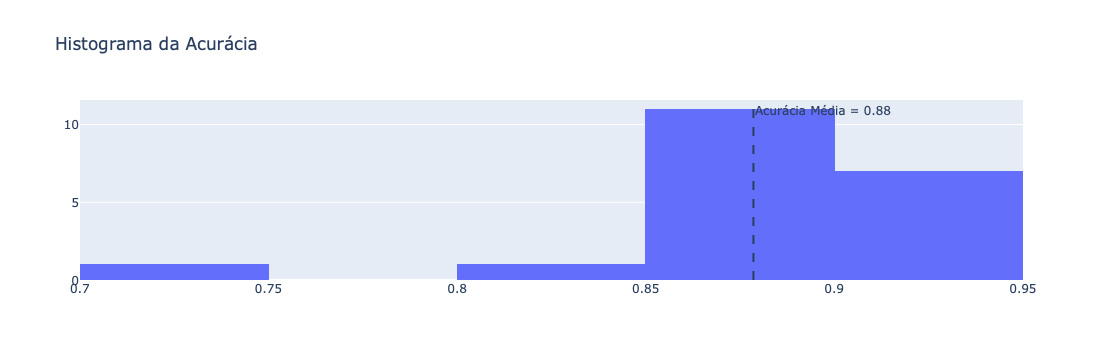

In [59]:
plot_accuracies(knn_res['accuracies'])

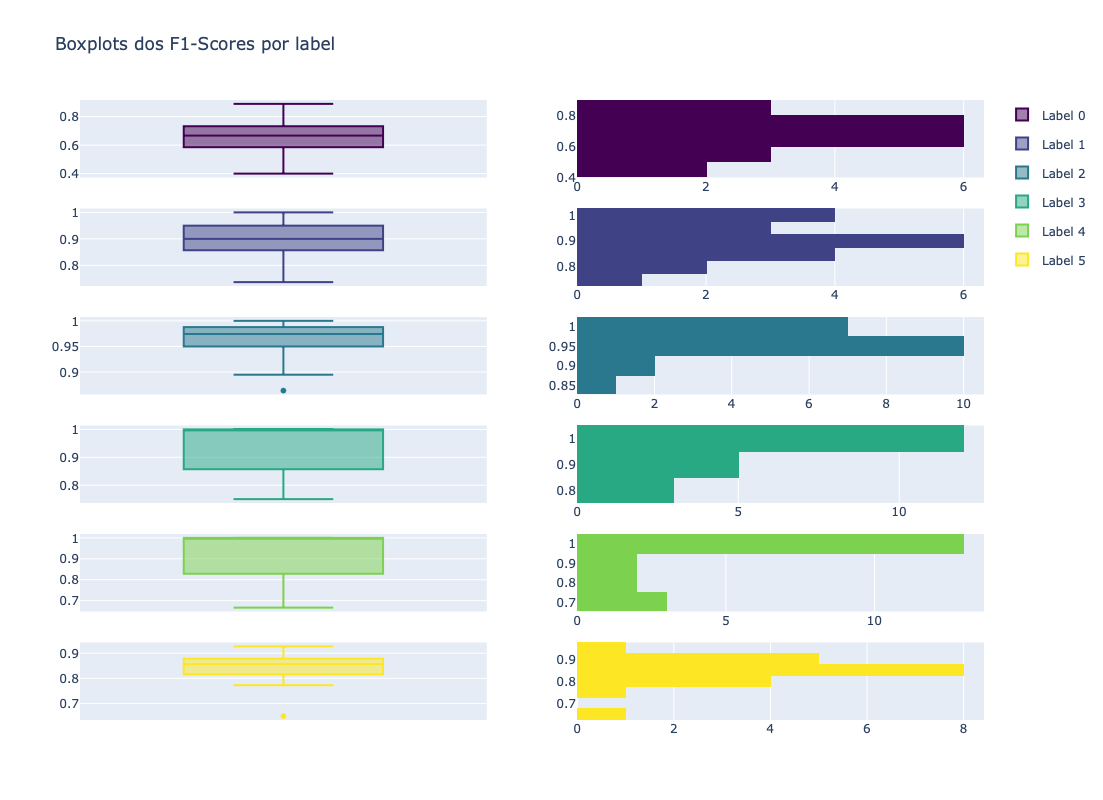

In [62]:
plot_f1_scores(knn_res['f1-scores'])

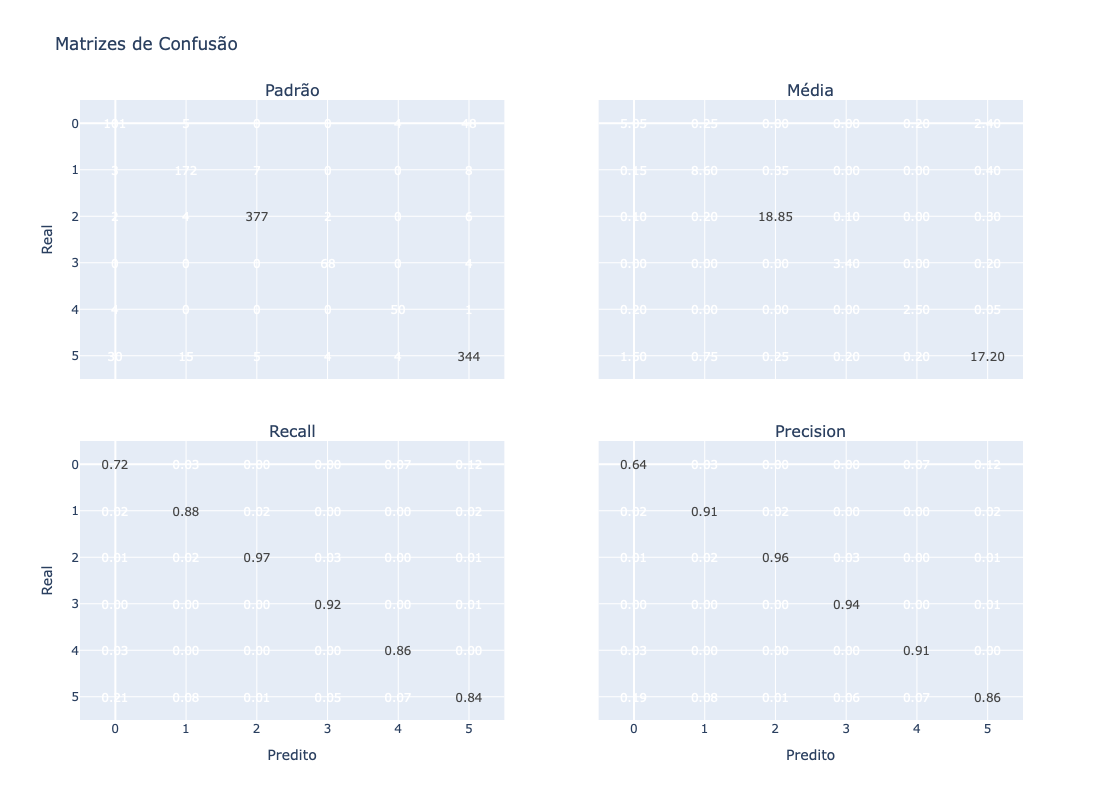

In [52]:
plot_confusion_matrix(knn_res['cms'])

#### Árvore de Decisão

In [168]:
tree_param_grid = {"max_depth": [5, 10, 20, 100]}

tree_model = DecisionTreeClassifier()
# tree_model = RandomForestClassifier()
tree_res = validate_model(tree_model, X, y, tree_param_grid, n_iter=20, n_trainval_splits=10)
print_res(tree_res)

===> ACURÁCIA MÉDIA <===
0.8627

===> MATRIZ DE CONFUSÃO GERAL <===
[[ 99   2   4   0   3  50]
 [  3 177   2   0   0   8]
 [  1   4 379   0   1   6]
 [  0   1   0  65   0   6]
 [  4   0   0   0  46   5]
 [ 46   2   8  11   7 328]]

===> RECALL, PRECISION E F1-SCORE MÉDIO <===
Label      | Recall     | Precision  | F1-Score  
------------------------------------------------
0          | 0.6286     | 0.6537     | 0.6272    
1          | 0.9311     | 0.9579     | 0.9399    
2          | 0.9692     | 0.9662     | 0.9667    
3          | 0.9042     | 0.8733     | 0.8779    
4          | 0.8417     | 0.8425     | 0.8177    
5          | 0.8154     | 0.8223     | 0.8136    


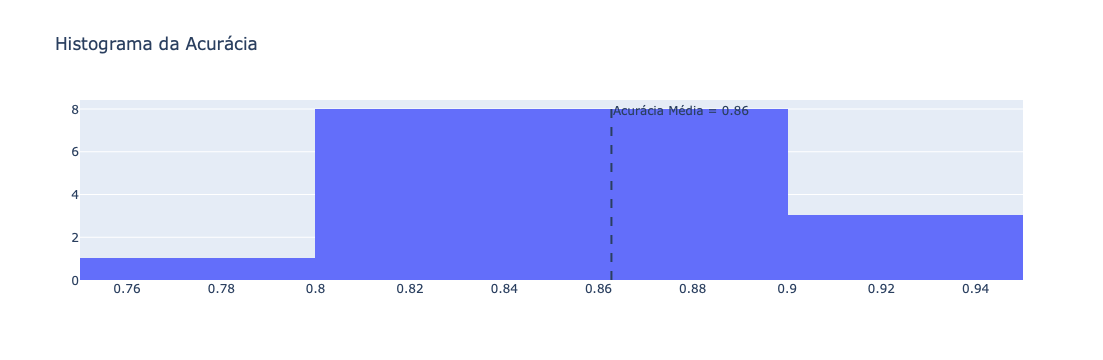

In [169]:
plot_accuracies(tree_res['accuracies'])

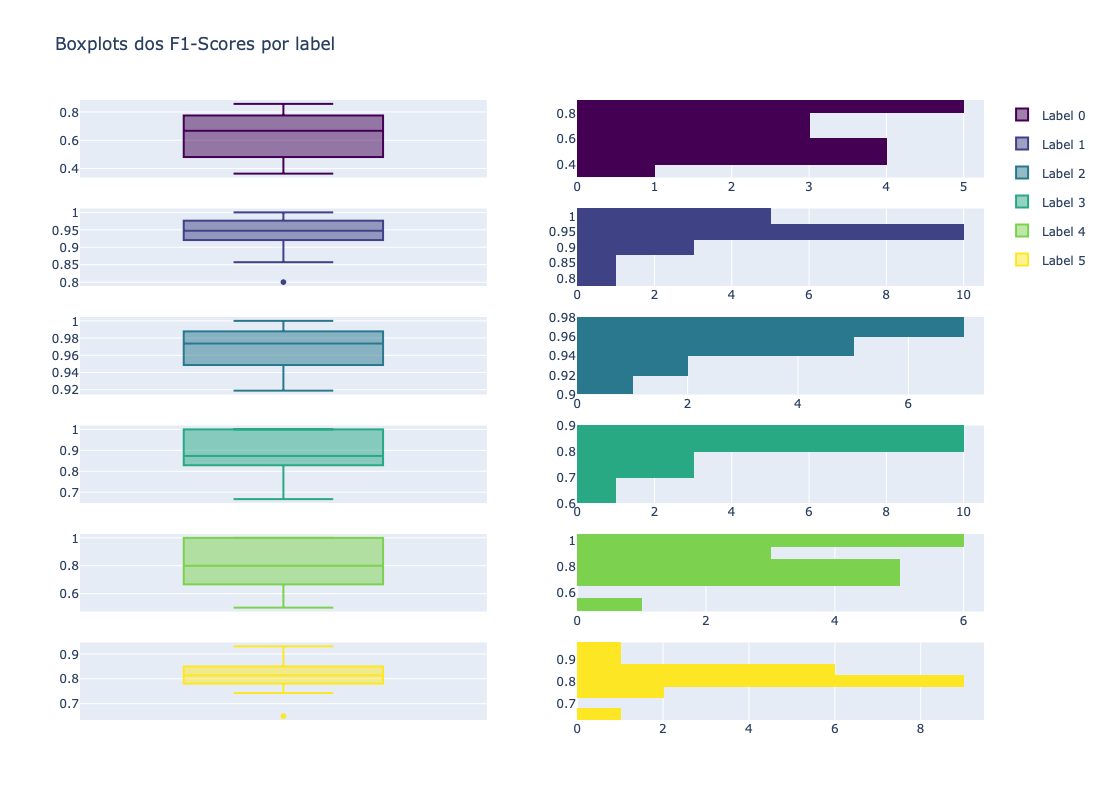

In [170]:
plot_f1_scores(tree_res['f1-scores'])

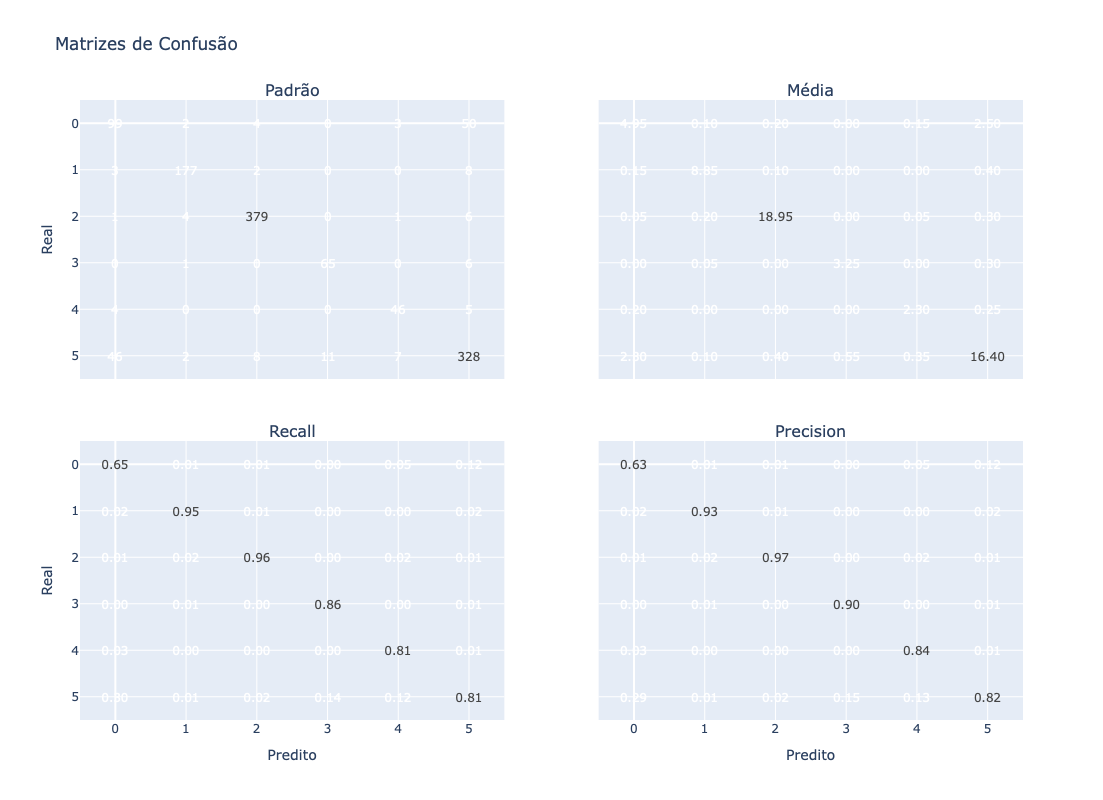

In [171]:
plot_confusion_matrix(tree_res['cms'])